<a href="https://colab.research.google.com/github/Remi908/Diffusion_Model/blob/main/Unet_4layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

 # Smaller Beta Schedule for DDPM
def smaller_beta_schedule(timesteps, start=1e-5, end=2e-3):
    return torch.linspace(start, end, timesteps)

 # Cosine Beta Schedule for Improved Noise Scheduling
def cosine_beta_schedule(timesteps, s=0.008):
    t = torch.arange(timesteps + 1, dtype=torch.float32) / timesteps
    alpha_bar = torch.cos((t + s) / (1 + s) * np.pi / 2) ** 2
    beta = 1 - (alpha_bar[1:] / alpha_bar[:-1])
    beta = torch.clamp(beta, 0.0001, 0.9999)  # Clamp to avoid instability
    return beta

 # Forward Diffusion Function
def forward_diffusion(x, t, beta_schedule):
    noise = torch.randn_like(x)
    alpha = torch.cumprod(1 - beta_schedule, dim=0)
    alpha_t = alpha[t].view(-1, 1, 1, 1)  # Adjust dimensions to match input
    x_t = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * noise
    return x_t, noise

In [18]:
# def double_conv(in_channels, out_channels, kernel_size=5, dropout_rate=0.1):
#     """
#     Two-layer convolutional block with ReLU activation and dropout.

#     Args:
#         in_channels (int): Number of input channels.
#         out_channels (int): Number of output channels.
#         kernel_size (int): Size of the convolutional kernel (3x3 or 5x5).
#         dropout_rate (float): Dropout probability.

#     Returns:
#         nn.Sequential: A sequential block of conv layers.
#     """
#     padding = kernel_size // 2  # Ensures the output size remains the same
#     return nn.Sequential(
#         nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
#         nn.ReLU(),
#         nn.Dropout(dropout_rate),
#         nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
#         nn.ReLU(),
#         nn.Dropout(dropout_rate)
#     )

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def double_conv(in_channels, out_channels, kernel_size=3, dropout_rate=0.1):
    """
    Two-layer convolutional block with ReLU activation and dropout.
    """
    padding = kernel_size // 2  # Ensures the output size remains the same
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
        nn.ReLU(),
        nn.Dropout(dropout_rate)
    )

class UNet(nn.Module):
    """
    U-Net model with adjusted upsampling to fix size mismatches.
    """
    def __init__(self, kernel_size=3, dropout_rate=0.1):
        super().__init__()
        # Encoder
        self.enc1 = double_conv(2, 64, kernel_size, dropout_rate)
        self.enc2 = double_conv(64, 128, kernel_size, dropout_rate)
        self.enc3 = double_conv(128, 256, kernel_size, dropout_rate)
        self.enc4 = double_conv(256, 512, kernel_size, dropout_rate)  # Added deeper layer

        # Decoder
        self.dec1 = double_conv(512 + 256, 256, kernel_size, dropout_rate)
        self.dec2 = double_conv(256 + 128, 128, kernel_size, dropout_rate)
        self.dec3 = double_conv(128 + 64, 64, kernel_size, dropout_rate)
        self.out = nn.Conv2d(64, 1, kernel_size=1)  # Final output layer

        # Pooling and Upsampling (Fixed using interpolation)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        # Encoding path
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Decoding path with skip connections (fixed size mismatch)
        d1 = self.dec1(torch.cat((F.interpolate(e4, size=e3.shape[2:], mode='bilinear', align_corners=False), e3), dim=1))
        d2 = self.dec2(torch.cat((F.interpolate(d1, size=e2.shape[2:], mode='bilinear', align_corners=False), e2), dim=1))
        d3 = self.dec3(torch.cat((F.interpolate(d2, size=e1.shape[2:], mode='bilinear', align_corners=False), e1), dim=1))

        return self.out(d3)  # Final output

# Example usage
model = UNet(kernel_size=5, dropout_rate=0.2)
print(model)


UNet(
  (enc1): Sequential(
    (0): Conv2d(2, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropou

In [30]:
# Denoising Model with Time-Step Embeddings
class DenoisingModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.unet = UNet()
        self.timestep_embedding = nn.Embedding(1000, 28 * 28)
    def forward(self, x, t):
        t_embed = self.timestep_embedding(t).view(t.size(0), 1, 28, 28)
        x = torch.cat((x, t_embed), dim=1)  # Concatenate input and time-step embedding
        return self.unet(x)
 # Data Augmentation for Robust Training
transform = transforms.Compose([
    transforms.RandomRotation(10),  # Randomly rotate images
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
 ])

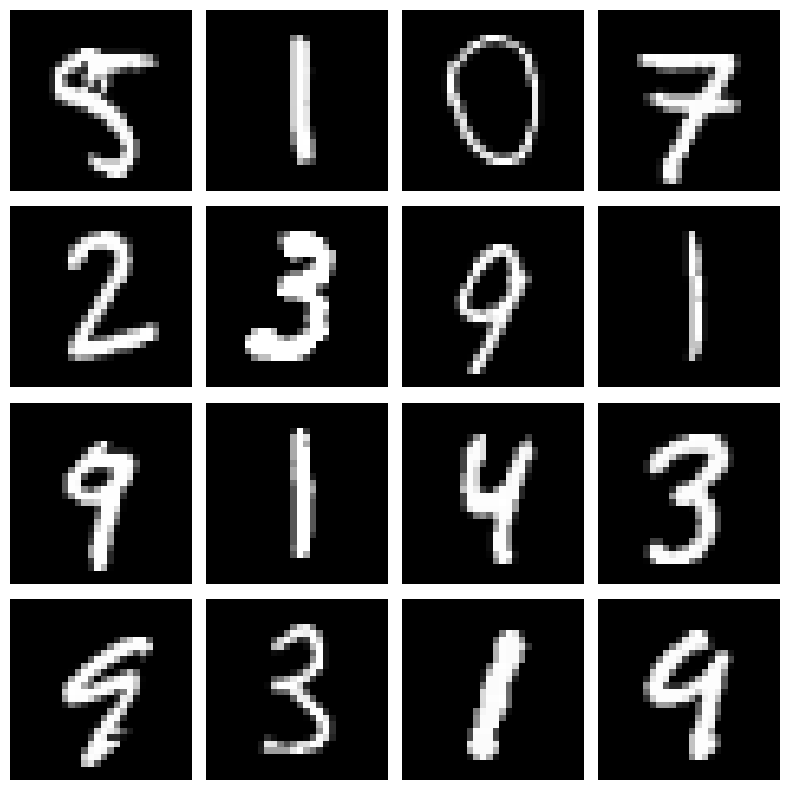

In [31]:
 # Data Preprocessing and Visualization
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1, 1]
 ])
 # Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
 # Create DataLoaders for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
 # Visualize the Data
def visualize_data(loader):
    images, labels = next(iter(loader))
    plt.figure(figsize=(8, 8))
    for i in range(16):  # Display 16 images
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i][0].numpy(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
visualize_data(train_loader)  # Visualize a batch of training data

In [32]:
 # Training Loop
def train_model():
    timesteps = 1000
    beta_schedule = cosine_beta_schedule(timesteps).to(torch.float32)
    model = DenoisingModel()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)  # Use AdamW with weight decay
    loss_fn = nn.MSELoss()
    num_epochs = 5
    for epoch in range(num_epochs):
        epoch_loss = 0
        model.train()   # Set the model to training mode
        for x, _ in train_loader:
            # Generate random timesteps
            t = torch.randint(0, timesteps, (x.size(0),), dtype=torch.long)
            # Apply forward diffusion to the input
            x_t, noise = forward_diffusion(x, t, beta_schedule)
            # Predict the noise using the model
            pred_noise = model(x_t, t)
            # Compute the loss
            loss = loss_fn(pred_noise, noise)
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Accumulate epoch loss
            epoch_loss += loss.item()
        # Display epoch loss
        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

In [33]:
def sample(model, shape, timesteps, beta_schedule):
    """
    Generates samples by reverse diffusion.
    Args:
        model (nn.Module): Trained denoising model.
        shape (tuple): Shape of the output tensor (batch_size, channels, height, width).
        timesteps (int): Total number of timesteps.
        beta_schedule (torch.Tensor): Predefined beta schedule.
    Returns:
        torch.Tensor: Generated samples (denoised images).
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        x = torch.randn(shape)  # Start with random noise
        alpha = torch.cumprod(1 - beta_schedule, dim=0)
        for t in reversed(range(timesteps)):
            beta_t = beta_schedule[t]
            alpha_t = alpha[t]
            timestep_tensor = torch.full((shape[0],), t, dtype=torch.long)  # Batch of timesteps
            pred_noise = model(x, timestep_tensor)  # Predict the noise
            x = (x - torch.sqrt(1 - alpha_t) * pred_noise) / torch.sqrt(alpha_t)
            if t > 0:  # Add noise unless it's the last step
                noise = torch.randn_like(x)
                x += torch.sqrt(beta_t) * noise
    return x  # Final denoised image

In [34]:
print("Starting training...")
train_model()

Starting training...
Epoch [1/5], Loss: 0.2241
Epoch [2/5], Loss: 0.1180
Epoch [3/5], Loss: 0.0967
Epoch [4/5], Loss: 0.0874
Epoch [5/5], Loss: 0.0825


Visualizing the diffusion process...


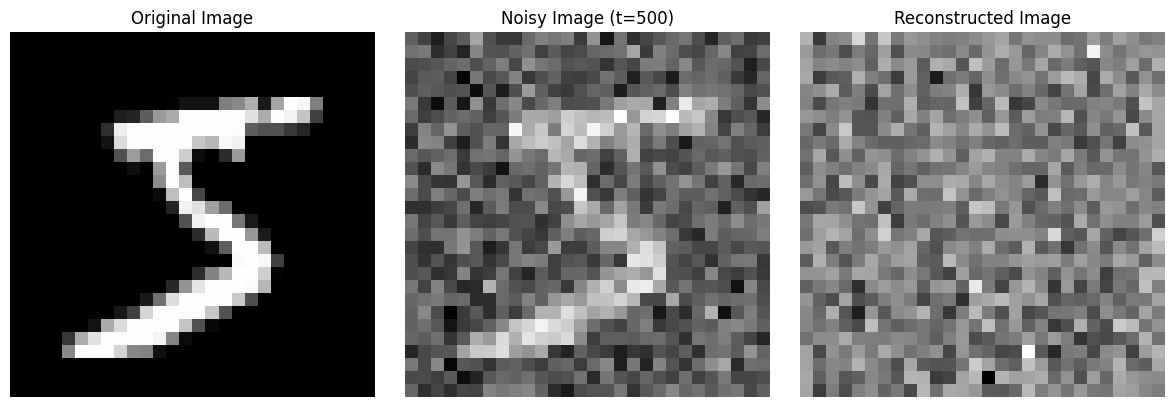

In [35]:
 # Function to visualize original, noisy, and reconstructed images
def visualize_diffusion_process(model, train_dataset, beta_schedule, timesteps=1000):
    """
    Visualizes the diffusion process:
    1. Original image from the dataset.
    2. Noisy version of the image at a selected timestep.
    3. Reconstructed image after reverse diffusion.
    Args:
        model (nn.Module): Trained denoising model.
        train_dataset (Dataset): Training dataset.
        beta_schedule (torch.Tensor): Predefined beta schedule.
        timesteps (int): Total number of timesteps.
    """
    # Pick a random image from the dataset
    sample_image, _ = train_dataset[0]  # Get the first image (ignore the label)
    sample_image = sample_image.unsqueeze(0)  # Add batch dimension
    # Apply forward diffusion
    t = timesteps // 2  # Pick a midpoint timestep
    x_t, noise = forward_diffusion(sample_image, torch.tensor([t]), beta_schedule)
    # Apply reverse diffusion
    reconstructed_image = sample(model, shape=x_t.shape, timesteps=t, beta_schedule=beta_schedule)
    # Visualize original, noisy, and reconstructed images
    plt.figure(figsize=(12, 4))
    # Original Image
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(sample_image[0, 0].cpu().numpy(), cmap='gray')
    plt.axis('off')
    # Noisy Image
    plt.subplot(1, 3, 2)
    plt.title(f"Noisy Image (t={t})")
    plt.imshow(x_t[0, 0].cpu().numpy(), cmap='gray')
    plt.axis('off')
    # Reconstructed Image
    plt.subplot(1, 3, 3)
    plt.title("Reconstructed Image")
    plt.imshow(reconstructed_image[0, 0].cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
 # Example Usage
if __name__ == "__main__":
    # Define hyperparameters and initialize beta schedule
    timesteps = 1000
    beta_schedule = smaller_beta_schedule(timesteps).to(torch.float32)
    # Ensure the model is loaded (trained or pre-trained)
    model = DenoisingModel()
    # Visualize diffusion process
    print("Visualizing the diffusion process...")
    visualize_diffusion_process(model, train_dataset, beta_schedule, timesteps=timesteps)